In [1]:
!echo "hello"

hello


In [4]:
import numpy as np
x = np.load('data/gsn_img_uint8.npy')

In [5]:
print(x.shape)

(2000, 128, 128, 3)


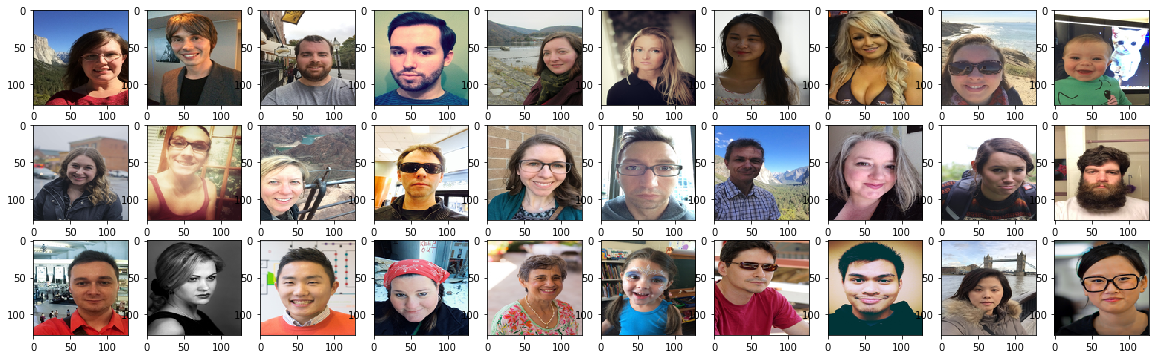

In [13]:
from matplotlib import pyplot as plt

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        sub.imshow(imgs[i], interpolation='nearest')

imshow_many(x[:30])